# Natural Language Processing - Text Mining with Twitter API

### Introduction 

Using Natural Language Processing we can extract relevant and insightful data from social media. In this demonstration I will use the Python Twitter API tweepy to stream data into my console and extract that data into a text file for Natural Language Procssing. 

In the past year we have seen the rise in fashion dominance of Adidas in the sneakers category. This was reflected in their stock price as Adidas have been climbing consistently in the past year.  We will look to twitter to help acertain this trend by comparing the number of relevant tweets between Adidas and Nike. 

### Streaming Data from Twitter

To start off we will stream data from Twitter using the tweepy API. We will capture tweets that contains keywords Nike and Adidas.

In [ ]:
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
 
access_token = "Access Token"
access_token_secret = "Access Token Secret"
consumer_key = "Consumer Key"
consumer_secret = "Consumer Secret"


class StdOutListener(StreamListener):

    def on_data(self, data):
        print data
        return True

    def on_error(self, status):
        print status


if __name__ == '__main__':

    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)

    #key word capture
    stream.filter(track=['Nike', 'Adidas'])

The code above was processed through Canopy and data was exported to a text file via the Canopy command steaming_data.py > data.text. Due to the lack of processing power of my laptop, I've only obtained roughly 3000 tweets.

### Dataframe Preparation

The next step is to create a dataframe to store the necessary information. For starters we will take in language and country for some quick visualizations. 

In [67]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

tweets_data_path = '/Users/data.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

tweets = pd.DataFrame()

tweets['text'] = map(lambda tweet: tweet.get('text', None),tweets_data)
tweets['lang'] = map(lambda tweet: tweet.get('lang',None),tweets_data)
tweets['country'] = map(lambda tweet: tweet.get('place',{}).get('country',{}) if tweet.get('place',None) != None else None, tweets_data)
tweets_by_lang = tweets['lang'].value_counts()

### Analyzing tweets

With dataframe created we can now use some of that information for some quick visualizations. 

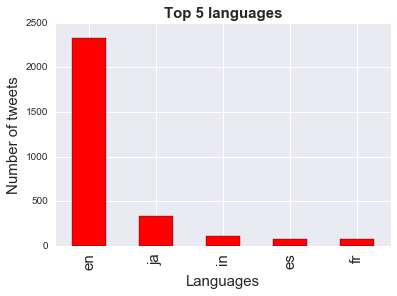

In [69]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

From the barchart above we can see that English was the primary language of the tweets collected. 

Next we will create new columns and extract information on tweets that are Nike or Adidas related. 

In [70]:
#some quick data cleaning to remove rows will null values
tweets = tweets.drop(tweets.index[[878,881,886,925]])

#function to return True if a certain word in found in the text
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

tweets['Nike'] = tweets['text'].apply(lambda tweet: word_in_text('nike', tweet))
tweets['Adidas'] = tweets['text'].apply(lambda tweet: word_in_text('adidas', tweet))

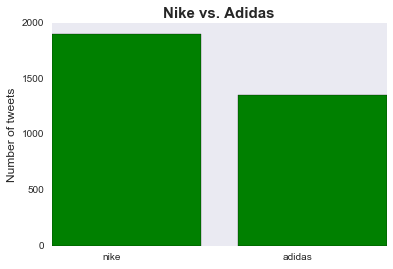

In [75]:
brands = ['nike', 'adidas']
tweets_by_brands = [tweets['Nike'].value_counts()[True], tweets['Adidas'].value_counts()[True]]
x_pos = list(range(len(brands)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_brands, width, alpha=1, color='g')
ax.set_ylabel('Number of tweets', fontsize=12)
ax.set_title('Nike vs Adidas', fontsize=15, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(brands)
plt.grid()

From the above barchart we can see that Nike is still ranked higher in terms of mentioned tweets. We will take this further and investigate whether this is still the case by placing some relevance filters. 

### Relevant data 

We've seen Nike ranked higher in terms of mentioned tweets, but now lets add in some relevant keywords. As our focus is sneakers, we will add in shoes, sneakers and kicks as relevant keywords. The code in the following section will take those keywords and look for tweets that are relevant. 

In [80]:
tweets['shoes'] = tweets['text'].apply(lambda tweet: word_in_text('shoes', tweet))
tweets['sneakers'] = tweets['text'].apply(lambda tweet: word_in_text('sneakers', tweet))
tweets['kicks'] = tweets['text'].apply(lambda tweet: word_in_text('kicks', tweet))

tweets['relevant'] = tweets['text'].apply(lambda tweet: word_in_text('shoes', tweet) or \
                                          word_in_text('sneakers', tweet) or word_in_text('kicks', tweet))


print tweets['shoes'].value_counts()[True]
print tweets['sneakers'].value_counts()[True]
print tweets['kicks'].value_counts()[True]
print tweets['relevant'].value_counts()[True]

623
59
46
701


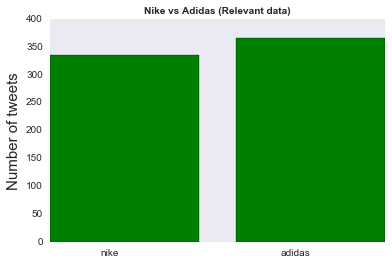

In [81]:
tweets_by_brand_rel = [tweets[tweets['relevant'] == True]['Nike'].value_counts()[True], 
                      tweets[tweets['relevant'] == True]['Adidas'].value_counts()[True]]
x_pos = list(range(len(brands)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_brand_rel, width,alpha=1,color='g')
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Nike vs Adidas (Relevant data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(brands)
plt.grid()

With the relevant keywords added we can now see that Adidas actually ranked higher. This is no surprise but helps ascertain that Adidas is now big player in the sneakers market.

Please note that the analysis and data above are for demonstration purposes only. For a more robust analysis, more data (tweets) is needed. 

### Extract Links from tweets 

In this last section we will pull links of relevant tweets into a new dataframe for further analysis.

In [97]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))
tweets_relevant = tweets[tweets['relevant'] == True]
tweets_relevant_with_link = tweets_relevant[tweets_relevant['link'] != '']

links_rel_nike =  tweets_relevant_with_link[tweets_relevant_with_link['Nike'] == True]['link']
links_rel_nike.head()

12     https://t.co/dTvEf6e1IM
17     https://t.co/qfSMYxTiN4
40     https://t.co/8Wc3LozPLu
43     https://t.co/6kWJNjI1fF
119    https://t.co/aAXTrXhWw1
Name: link, dtype: object

Thank you for reading through this Natural Language Processing demonstration. I hope this was an enjoyable read. 

Mitsuaki Takeo